# 네이버 영화평 감상분석

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import joblib
import re

In [3]:
train_df = pd.read_table('./data/ratings_train.txt')
test_df = pd.read_table('./data/ratings_test.txt')

In [4]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

데이터 전처리

In [5]:
train_df['document'].nunique()

146182

In [6]:
# 중복이 있다면 중복 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

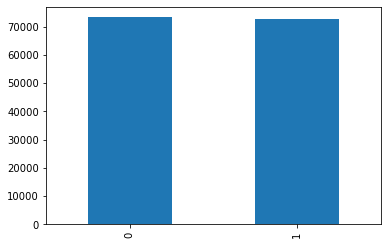

In [7]:
# 긍정, 부정 레이블 값의 분포
train_df.label.value_counts().plot(kind='bar')
plt.show()

In [8]:
train_df.label.value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [9]:
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [10]:
train_df = train_df.dropna(how = 'any')
train_df.shape

(146182, 3)

In [11]:
test_df['document'].nunique()

49157

In [12]:
# 중복이 있다면 중복 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49158, 3)

In [13]:
# null값 제거
test_df = test_df.dropna(how = 'any')
test_df.shape

(49157, 3)

텍스트 전처리

In [14]:
# 트레인 셋
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
# 빈 데이터를 nan값으로
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [16]:
# null값 
train_df = train_df.dropna(how = 'any')
train_df.shape

(145791, 3)

In [17]:
# 전처리된 csv
train_df.to_csv('./data/movie_train.tsv', sep = '\t')

In [18]:
# 테스트 셋
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()


id            0
document    162
label         0
dtype: int64

In [19]:
# null값 
test_df = test_df.dropna(how = 'any')
test_df.shape

(48995, 3)

In [20]:
test_df.to_csv('./data/movie_test.tsv', sep = '\t')

토큰화

In [32]:
from konlpy.tag import Okt
okt = Okt()

In [33]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [34]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [35]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [36]:
train_df

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [37]:
test_df

,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [38]:
for sentence in tqdm(train_df['document'][:100]):
    print(sentence)

100%|██████████| 100/100 [00:00<00:00, 48657.82it/s]아 더빙 진짜 짜증나네요 목소리
흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
교도소 이야기구먼 솔직히 재미는 없다평점 조정
사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움
원작의 긴장감을 제대로 살려내지못했다
별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫겟다 납치감금만반복반복이드라마는 가족도없다 연기못하는사람만모엿네
액션이 없는데도 재미 있는 몇안되는 영화
왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나
걍인피니트가짱이다진짜짱이다
볼때마다 눈물나서 죽겠다년대의 향수자극허진호는 감성절제멜로의 달인이다
울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해
담백하고 깔끔해서 좋다 신문기사로만 보다 보면 자꾸 잊어버린다 그들도 사람이었다는 것을
취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지
ㄱ냥 매번 긴장되고 재밋음ㅠㅠ
참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다그냥 까고싶어서 안달난것처럼 보인다
굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐
이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드
약탈자를 위한 변명 이라 저놈들은 착한놈들 절대 아닌걸요
나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님
보면서 웃지 않는 건 불가능하다
재미없다 지루하고 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남바베트의 만찬은 이야기도 있고 음식 보는재미도 있는데  이건 볼게없다 음식도 별로 안나오고 핀란드 풍경이라도 구경할랫는데 그것도 별로 안나옴 ㅡㅡ
절대 평범한 영화가 아닌 수작이라는걸 말씀드립니

In [39]:
X_train = []
for sentence in tqdm(train_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_train.append(temp_X)

100%|██████████| 145791/145791 [07:35<00:00, 319.90it/s]


In [40]:
X_test = []
for sentence in tqdm(test_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_test.append(temp_X)

100%|██████████| 48995/48995 [02:37<00:00, 311.36it/s]


In [41]:
y_train = train_df.label.values
print(y_train)
y_test = test_df.label.values
print(y_test)

[0 1 0 ... 0 1 0]
[1 0 0 ... 0 0 0]


In [43]:
import pickle
# 리스트 같은거 저장할 때 매우 좋다.
with open('./data/movie_X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f, pickle.HIGHEST_PROTOCOL)
with open('./data/movie_X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f, pickle.HIGHEST_PROTOCOL)   

In [44]:
with open('./data/movie_X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/movie_X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

데이터가 문자열이므로 CounterVectorizer로 숫자로 바꾼 다음 LogisticRegression 분류

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

1. CountVectorizer + 로지스틱 회귀

In [49]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer(ngram_range=(1,2))),
    ('lr_clf', LogisticRegression())
])
params = ({
    'count_vect__max_df': [500],
    'lr_clf__C': [1]
})

In [50]:
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3,
                         scoring='accuracy', verbose=1, n_jobs=-1)
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.6s finished
{'count_vect__max_df': 500, 'lr_clf__C': 1} 0.8142409339396807


In [51]:
best_count_lr = grid_pipe.best_estimator_
pred_count_lr = best_count_lr.predict(X_test)
accuracy_score(y_test, pred_count_lr)

0.8119604041228696

In [52]:
joblib.dump(best_count_lr, '../../Flask/3_module/static/model/hangul_count_lr.pkl')

['../../Flask/3_module/static/model/hangul_count_lr.pkl']

2. CountVectorizer + 나이브 베이즈

In [53]:
nb = MultinomialNB()
nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [54]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer(ngram_range=(1,2))),
    ('nb', MultinomialNB())
])
params = ({
    'count_vect__max_df': [400],
    'nb__alpha':[2.0]
})

In [55]:
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3,
                         scoring='accuracy', verbose=1, n_jobs=-1)
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.3s finished
{'count_vect__max_df': 400, 'nb__alpha': 2.0} 0.8197008045764141


In [56]:
best_count_nb = grid_pipe.best_estimator_
pred_count_nb = best_count_nb.predict(X_test)
accuracy_score(y_test, pred_count_nb)

0.818491682824778

In [57]:
joblib.dump(best_count_nb, '../../Flask/3_module/static/model/hangul_count_nb.pkl')

['../../Flask/3_module/static/model/hangul_count_nb.pkl']

3. TfidfVectorizer + LogisticRegression

In [58]:
# 옛날에 tfidf 했을 땐 TfidfVectorizer에 tokenizer 옵션을 줬었는데
# 위에 X_train, y_train이 이미 형태소 분석이 되어 있어 필요 없다.
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(ngram_range=(1,2))),
    ('lr_clf', LogisticRegression())
])
params = ({
    'tfidf_vect__max_df': [400],
    'lr_clf__C': [2]
})

In [59]:
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3,
                         scoring='accuracy', verbose=1, n_jobs=-1)
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.8s finished
{'lr_clf__C': 2, 'tfidf_vect__max_df': 400} 0.8120665884725394


In [60]:
best_tfidf_lr = grid_pipe.best_estimator_
pred_tfidf_lr = best_tfidf_lr.predict(X_test)
accuracy_score(y_test, pred_tfidf_lr)

0.8088172262475762

In [61]:
joblib.dump(best_tfidf_lr, '../../Flask/3_module/static/model/hangul_tfidf_lr.pkl')

['../../Flask/3_module/static/model/hangul_tfidf_lr.pkl']

4. TfidfVectorizer + 나이브 베이즈

In [62]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer(ngram_range=(1,2))),
    ('nb', MultinomialNB())
])
params = ({
    'count_vect__max_df': [400],
    'nb__alpha':[2.0]
})

In [63]:
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3,
                         scoring='accuracy', verbose=1, n_jobs=-1)
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished
{'count_vect__max_df': 400, 'nb__alpha': 2.0} 0.8197008045764141


In [64]:
best_tfidf_nb = grid_pipe.best_estimator_
pred_tfidf_nb = best_tfidf_nb.predict(X_test)
accuracy_score(y_test, pred_tfidf_nb)

0.818491682824778

In [65]:
joblib.dump(best_tfidf_nb, '../../Flask/3_module/static/model/hangul_tfidf_nb.pkl')

['../../Flask/3_module/static/model/hangul_tfidf_nb.pkl']

실제 데이터

In [66]:
review = "진짜 개노잼이다... 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ"

In [67]:
import re
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
review

'진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ'

In [68]:
review = okt.morphs(review, stem = True)

In [69]:
temp_X = ' '.join([word for word in review if not word in stopwords])
temp_X = [temp_X]
temp_X

['진짜 개 노잼 이다 편이 랑 같다 감독 맞다 러닝 타임 기다 개 지루함 ㄹㅇ']

In [ ]:
review_cvect = cvect.transform(temp_X)

In [39]:
pred = lr_clf.predict(review_cvect)
# 0은 부정
pred[0]

0

In [40]:
review2 = "이런 사랑영화가 다시 나올 수 있을까?"
review2 = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review2)
temp_X = ' '.join([word for word in review2 if not word in stopwords])
temp_X = [temp_X]
review_cvect = cvect.transform(temp_X)
pred = lr_clf.predict(review_cvect)
# 0은 부정
print(temp_X)
pred[0]

['런   사 랑 영 화   다 시   나 올   수   있 을 까']


0

In [41]:
# 리스트에 여러개 리뷰가 들어와 있을 때
reviews = ['진짜 개노잼이다... 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ',"이런 사랑영화가 다시 나올 수 있을까?"]

In [42]:
reviews = list(map(lambda x: re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', x), reviews))
print(reviews)

['진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ', '이런 사랑영화가 다시 나올 수 있을까']


In [43]:
review_list = []
for review in reviews:
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
    morphs = okt.morphs(review)
    tmp = ' '.join([word for word in review if not word in stopwords])
    review_list.append(tmp)

In [44]:
review_cvect = cvect.transform(review_list)
pred = lr_clf.predict(review_cvect)

In [45]:
# 둘 다 부정
pred

array([0, 0], dtype=int64)

최적 파라미터 찾기

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [47]:
pipeline = Pipeline([
    ('cvector', CountVectorizer()),
    ('lr_clf', LogisticRegression())
])
params = {
    'cvector__ngram_range': [(1,1),(1,2)],
    'cvector__max_df': [0.9, 0.95, 0.99],
    'lr_clf__C': [1, 3, 5]
}
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, verbose=1, scoring='accuracy')
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_ )

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 12.3min finished
{'cvector__max_df': 0.9, 'cvector__ngram_range': (1, 2), 'lr_clf__C': 1} 0.8411904712910948


In [51]:
pred = grid_pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'cvector + lr_clf 정확도: {acc:.4f}')

cvector + lr_clf 정확도: 0.8466
